In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline
import seaborn as sns

**About Dataset**

This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv


**Load Data From CSV File**

In [ ]:
loan = pd.read_csv("/content/drive/MyDrive/Self-Learning/Loan/loan_train.csv")
loan.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [ ]:
loan.shape

(346, 10)

# **Data Wrangling**

In [ ]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      346 non-null    int64 
 1   Unnamed: 0.1    346 non-null    int64 
 2   loan_status     346 non-null    object
 3   Principal       346 non-null    int64 
 4   terms           346 non-null    int64 
 5   effective_date  346 non-null    object
 6   due_date        346 non-null    object
 7   age             346 non-null    int64 
 8   education       346 non-null    object
 9   Gender          346 non-null    object
dtypes: int64(5), object(5)
memory usage: 27.2+ KB


In [ ]:
# Convert Date from object type into Datetype
loan['due_date'] = pd.to_datetime(loan['due_date'])
loan['effective_date'] = pd.to_datetime(loan['effective_date'])

In [ ]:
# Check Missing Values
loan.isna().any()  # No Missing values

Unnamed: 0        False
Unnamed: 0.1      False
loan_status       False
Principal         False
terms             False
effective_date    False
due_date          False
age               False
education         False
Gender            False
dtype: bool

In [ ]:
# Check unusual values
loan.describe(include = 'all')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
count,346.000000,346.000000,346,346.000000,346.000000,346,346,346.000000,346,346
unique,NaN,NaN,2,NaN,NaN,7,23,NaN,4,2
top,NaN,NaN,PAIDOFF,NaN,NaN,2016-09-11 00:00:00,2016-10-10 00:00:00,NaN,High School or Below,male
freq,NaN,NaN,260,NaN,NaN,166,90,NaN,151,294
first,NaN,NaN,NaN,NaN,NaN,2016-09-08 00:00:00,2016-09-16 00:00:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,2016-09-14 00:00:00,2016-11-12 00:00:00,NaN,NaN,NaN
mean,202.167630,202.167630,NaN,943.641618,22.653179,NaN,NaN,30.939306,NaN,NaN
std,115.459715,115.459715,NaN,109.425530,7.991006,NaN,NaN,6.039418,NaN,NaN
min,0.000000,0.000000,NaN,300.000000,7.000000,NaN,NaN,18.000000,NaN,NaN
25%,107.250000,107.250000,NaN,900.000000,15.000000,NaN,NaN,27.000000,NaN,NaN


# **Data Exploration**

In [ ]:
loan['loan_status'].value_counts()
# Paidoff: 260 people, collection: 86 people

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

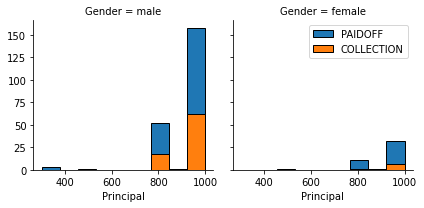

In [ ]:
bins = np.linspace(loan.Principal.min(), loan.Principal.max(), 10)
g = sns.FacetGrid(loan, col="Gender", hue="loan_status", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

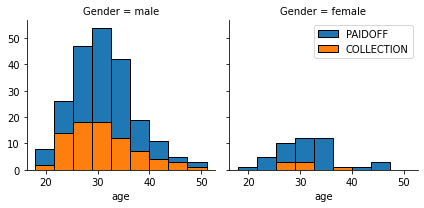

In [ ]:
bins = np.linspace(loan.age.min(), loan.age.max(), 10)
g = sns.FacetGrid(loan, col="Gender", hue="loan_status",  col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

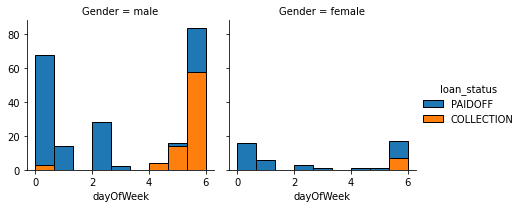

In [ ]:
# Inspect day of week people get the loan
loan['dayOfWeek'] = loan['effective_date'].dt.dayofweek
bins = np.linspace(loan.dayOfWeek.min(), loan.dayOfWeek.max(),10)
g = sns.FacetGrid(loan, col="Gender", hue="loan_status", col_wrap=2)
g.map(plt.hist, 'dayOfWeek', bins=bins, ec='k')

g.add_legend()
plt.show()
# Males who get loan on weekends do not usually pay it off

We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [ ]:
loan['weekend'] = loan['dayOfWeek'].apply(lambda x: 1 if (x>3)  else 0)
loan.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayOfWeek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


In [ ]:
# Paidoff rate and collection rate in each gender
loan.groupby('Gender')['loan_status'].value_counts(normalize=True)

# 86.5% females paidoff loans, 73% males paidoff loans

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

It showed that 86.5% females paidoff loans, 73% males paidoff loans.
The data is entirely imbalance.

**One Hot Encoding**


Convert Categorical Features to numerical values

In [ ]:
# Features before encoding
loan[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,male,High School or Below
1,1000,30,33,female,Bechalor
2,1000,15,27,male,college
3,1000,30,28,female,college
4,1000,30,29,male,college


In [ ]:
# Convert Male and Female to (0,1)
loan['Gender'].replace(to_replace= ['male','female'], value=[0,1], inplace = True)

**One Hot Encoding**


Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame

In [ ]:
Feature = loan[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(loan['education'])], axis=1)

In [ ]:
Feature.drop(['Master or Above'], axis = 1,inplace=True)

In [ ]:
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


**Feature Selection**

In [ ]:
# Define Feature sets X
X=Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [ ]:
y = loan['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

**Data Normalization**

Data Standardization give data zero mean and unit variance (technically should be done after train test split)

In [ ]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

Data Imbalance
Since the data is imbalance, meaning that there are much more people paying off compared to those who do not, we resampled the train dataset. In this case, the models can correctly learn to classify "collection" group.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


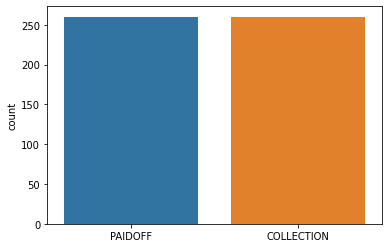

In [ ]:
from imblearn.over_sampling import RandomOverSampler

os = RandomOverSampler(random_state=2021)
os.fit(X, y)
X_resampled, Y_resampled = os.fit_resample(X, y)
sns.countplot(Y_resampled)

**Data Preparation**

In [ ]:
print(X_resampled.shape)
print(Y_resampled.shape)

(520, 8)
(520,)


In [ ]:
set(Y_resampled)

{'COLLECTION', 'PAIDOFF'}

In [ ]:
intY = np.array([0]*Y_resampled.shape[0])
intY[Y_resampled=='COLLECTION'] = 0
intY[Y_resampled=='PAIDOFF'] = 1
intY[:5]

array([1, 1, 1, 1, 1])

**Train-Valid Split**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Split the data into 70% train set and 30% valid set
np.random.seed(2021)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_resampled,intY, test_size=0.3)

In [ ]:
print("Train dataset:", X_train.shape, Y_train.shape)
print("Valid dataset:", X_valid.shape, Y_valid.shape)

Train dataset: (364, 8) (364,)
Valid dataset: (156, 8) (156,)


# **Classification - Modelling**

**K Nearest Neighbor (KNN)**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
np.random.seed(2021)

In [ ]:
# Finding the optimal K in KNN Model
ListKNN = []
K = 51
Ks = range(1,K)
mean_acc_KNN = np.zeros((K-1))
for k in Ks:
  m_KNN = KNeighborsClassifier(n_neighbors=k)
  m_KNN.fit(X_train,Y_train)
  ListKNN.append(m_KNN)
  score = round(m_KNN.score(X_valid, Y_valid),4)
  mean_acc_KNN[k-1] = score
  print(f'The Accuracy of {k}th K: {score}')

The Accuracy of 1th K: 0.8013
The Accuracy of 2th K: 0.7628
The Accuracy of 3th K: 0.7179
The Accuracy of 4th K: 0.7372
The Accuracy of 5th K: 0.7628
The Accuracy of 6th K: 0.7436
The Accuracy of 7th K: 0.75
The Accuracy of 8th K: 0.7244
The Accuracy of 9th K: 0.7244
The Accuracy of 10th K: 0.6987
The Accuracy of 11th K: 0.7179
The Accuracy of 12th K: 0.7051
The Accuracy of 13th K: 0.7372
The Accuracy of 14th K: 0.7372
The Accuracy of 15th K: 0.7244
The Accuracy of 16th K: 0.7115
The Accuracy of 17th K: 0.7179
The Accuracy of 18th K: 0.7436
The Accuracy of 19th K: 0.7308
The Accuracy of 20th K: 0.7179
The Accuracy of 21th K: 0.7244
The Accuracy of 22th K: 0.7244
The Accuracy of 23th K: 0.7308
The Accuracy of 24th K: 0.7244
The Accuracy of 25th K: 0.7372
The Accuracy of 26th K: 0.7372
The Accuracy of 27th K: 0.7564
The Accuracy of 28th K: 0.7436
The Accuracy of 29th K: 0.75
The Accuracy of 30th K: 0.7372
The Accuracy of 31th K: 0.75
The Accuracy of 32th K: 0.7372
The Accuracy of 33th K:

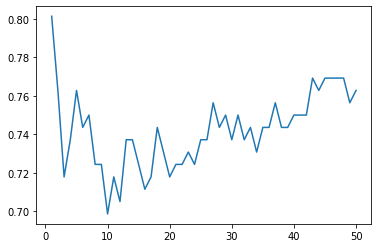

In [ ]:
plt.plot(Ks, mean_acc_KNN)

In [ ]:
print(f'The best accuracy: {mean_acc_KNN.max()} at K = {mean_acc_KNN.argmax()+1}' )

The best accuracy: 0.8013 at K = 1


From the validation dataset accuracy, we can find that K=1 has the highest accuracy. Thus, we set the optimal KNN model with parameter n_neighbors=1.

In [ ]:
# The optimal K for KNN model
m_KNN_best = ListKNN[mean_acc_KNN.argmax()]
m_KNN_best.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

**Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
ListDT = []
Depth = 51
mean_acc_DT = np.zeros(Depth-1)

for i in range(1,Depth):
  m_DT = DecisionTreeClassifier(random_state=2021, max_depth=i)
  m_DT.fit(X_train, Y_train)
  score_DT = round(m_DT.score(X_valid, Y_valid),4)
  mean_acc_DT[i-1] = score_DT
  ListDT.append(m_DT)
  print(f'Validation Accuracy: {score_DT}')

Validation Accuracy: 0.7692
Validation Accuracy: 0.7885
Validation Accuracy: 0.7372
Validation Accuracy: 0.8013
Validation Accuracy: 0.8077
Validation Accuracy: 0.8013
Validation Accuracy: 0.7692
Validation Accuracy: 0.7692
Validation Accuracy: 0.7885
Validation Accuracy: 0.7949
Validation Accuracy: 0.8077
Validation Accuracy: 0.8141
Validation Accuracy: 0.8205
Validation Accuracy: 0.7949
Validation Accuracy: 0.8013
Validation Accuracy: 0.8077
Validation Accuracy: 0.8077
Validation Accuracy: 0.8077
Validation Accuracy: 0.8077
Validation Accuracy: 0.8077
Validation Accuracy: 0.8077
Validation Accuracy: 0.8077
Validation Accuracy: 0.8077
Validation Accuracy: 0.8077
Validation Accuracy: 0.8077
Validation Accuracy: 0.8077
Validation Accuracy: 0.8077
Validation Accuracy: 0.8077
Validation Accuracy: 0.8077
Validation Accuracy: 0.8077
Validation Accuracy: 0.8077
Validation Accuracy: 0.8077
Validation Accuracy: 0.8077
Validation Accuracy: 0.8077
Validation Accuracy: 0.8077
Validation Accuracy:

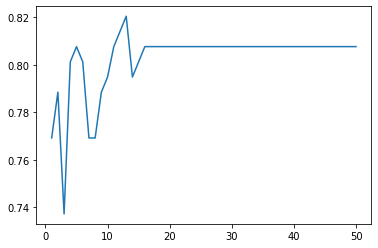

In [ ]:
plt.plot(range(1,Depth), mean_acc_DT)

In [ ]:
print(f'The best accuracy: {mean_acc_DT.max()} at K = {mean_acc_DT.argmax()+1}' )

The best accuracy: 0.8205 at K = 13


In [ ]:
# The best decision tree model was at max_depth = 13
m_DT_best = ListDT[mean_acc_DT.argmax()]
m_DT_best.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=13, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2021, splitter='best')

**SVM**

In [ ]:
from sklearn import svm

In [ ]:
kernals = ['linear', 'poly', 'rbf', 'sigmoid']
gammas = ['scale','auto']
mean_acc_SVM = np.zeros(8)
ListSVM = []
i=0
for kernal in kernals:
  for gamma in gammas:

    m_SVM = svm.SVC(kernel=kernal, gamma=gamma)
    m_SVM.fit(X_train, Y_train)
    score_SVM = round(m_SVM.score(X_valid, Y_valid),4)
    mean_acc_SVM[i] = score_SVM
    ListSVM.append(m_SVM)
    i+=1
    print(f'Validation Accuracy: {score_SVM}')

Validation Accuracy: 0.7179
Validation Accuracy: 0.7179
Validation Accuracy: 0.75
Validation Accuracy: 0.75
Validation Accuracy: 0.7628
Validation Accuracy: 0.7628
Validation Accuracy: 0.6538
Validation Accuracy: 0.6538


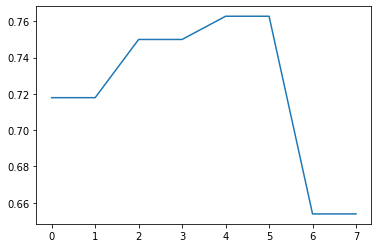

In [ ]:
plt.plot(range(len(ListSVM)), mean_acc_SVM)

In [ ]:
print(f'The best accuracy: {mean_acc_SVM.max()} is the {mean_acc_SVM.argmax()+1}th model' )

The best accuracy: 0.7628 is the 5th model


In [ ]:
m_SVM_best = ListSVM[mean_acc_SVM.argmax()]
m_SVM_best.fit(X_train, Y_train)
## The 5th model has kernal = 'rbf', and gamma = 'scale'

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

**Logistic Regression**

In [ ]:
from sklearn import linear_model

In [ ]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
ListLR = []
mean_acc_LR = np.zeros(len(solvers))
i=0

for solver in solvers:
  m_LR = linear_model.LogisticRegression(solver=solver)
  m_LR.fit(X_train,Y_train)
  score_LR = m_LR.score(X_valid, Y_valid)
  ListLR.append(m_LR)
  mean_acc_LR[i]=score_LR
  i+=1
  print(f'Validation Accuracy: {score_LR}')

Validation Accuracy: 0.717948717948718
Validation Accuracy: 0.717948717948718
Validation Accuracy: 0.717948717948718
Validation Accuracy: 0.717948717948718
Validation Accuracy: 0.717948717948718


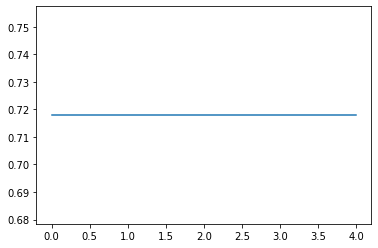

In [ ]:
plt.plot(range(len(ListLR)),mean_acc_LR)
# All five solver performs the same. Thus, need not adjust parameter solver.

In [ ]:
print(f'The best accuracy: {mean_acc_LR.max()} is the {mean_acc_LR.argmax()+1}th model' )

The best accuracy: 0.717948717948718 is the 1th model


# **Model Evaluation Using Test Dataset**

In [ ]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

Download test set:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Self-Learning/Loan/loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male



 **TestSet Preparation**

In [ ]:
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
testSet = test_df.iloc[:,2:]
testSet.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [ ]:
testSet['Gender'].replace(to_replace= ['male','female'], value=[0,1], inplace = True)

In [ ]:
testSet['dayOfWeek'] = testSet['effective_date'].dt.dayofweek
testSet['weekend'] = testSet['dayOfWeek'].apply(lambda x: 1 if (x>3)  else 0)
testSet.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayOfWeek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [ ]:
# Data Encoding
Feature = testSet[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(loan['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)


In [ ]:
testX = Feature
testX.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000.0,30.0,50.0,1.0,0.0,0,1,0
1,300.0,7.0,35.0,0.0,1.0,1,0,0
2,1000.0,30.0,43.0,1.0,1.0,0,0,1
3,1000.0,30.0,26.0,0.0,1.0,0,0,1
4,800.0,15.0,29.0,0.0,1.0,0,0,1


In [ ]:
print(testX.shape)
testX.isna().any()

(346, 8)


Principal                True
terms                    True
age                      True
Gender                   True
weekend                  True
Bechalor                False
High School or Below    False
college                 False
dtype: bool

In [ ]:
testX.dropna(inplace=True)
testX.shape

(54, 8)

In [ ]:
testY = testSet['loan_status']
testY = pd.DataFrame(testY)
testY.head()

,loan_status
0,PAIDOFF
1,PAIDOFF
2,PAIDOFF
3,PAIDOFF
4,PAIDOFF


In [ ]:
inttestY = np.array([0]*testY.shape[0])
testY[testY=='COLLECTION'] = 0
testY[testY=='PAIDOFF']    = 1
inttestY = testY.iloc[:,0].values

In [ ]:
inttestY

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=object)

**KNN**

In [ ]:
pred_KNN = m_KNN_best.predict(testX)
pred_KNN = pd.DataFrame(pred_KNN)
pred_KNN.head()

,0
0,COLLECTION
1,COLLECTION
2,PAIDOFF
3,PAIDOFF
4,PAIDOFF


In [ ]:
for param in ['weighted', 'micro', 'macro']:  
    print(param, " jaccard_score=", round(jaccard_score(testY, pred_KNN, average=param),4))  

weighted  jaccard_score= 0.4284
micro  jaccard_score= 0.4026
macro  jaccard_score= 0.3943


In [ ]:
for param in ['weighted', 'micro', 'macro']:  
    print(param, " f1_score=", round(f1_score(testY, pred_KNN, average=param),4))  

weighted  f1_score= 0.5971
micro  f1_score= 0.5741
macro  f1_score= 0.5619


**Decision Tree**

In [ ]:
pred_DT = m_DT_best.predict(testX)
pred_DT = pd.DataFrame(pred_DT)
pred_DT.head()

,0
0,PAIDOFF
1,COLLECTION
2,PAIDOFF
3,PAIDOFF
4,PAIDOFF


In [ ]:
for param in ['weighted', 'micro', 'macro']:  
    print(param, " jaccard_score=", round(jaccard_score(testY, pred_DT, average=param),4))  

weighted  jaccard_score= 0.4928
micro  jaccard_score= 0.4595
macro  jaccard_score= 0.4255


In [ ]:
for param in ['weighted', 'micro', 'macro']:  
    print(param, " f1_score=", round(f1_score(testY, pred_DT, average=param),4))  

weighted  f1_score= 0.6502
micro  f1_score= 0.6296
macro  f1_score= 0.5833


**SVM**

In [ ]:
pred_SVM = m_SVM_best.predict(testX)
pred_SVM = pd.DataFrame(pred_SVM)
pred_SVM.head()

,0
0,PAIDOFF
1,PAIDOFF
2,PAIDOFF
3,PAIDOFF
4,PAIDOFF


In [ ]:
for param in ['weighted', 'micro', 'macro']:  
    print(param, " jaccard_score=", round(jaccard_score(testY, pred_SVM, average=param),4))  

weighted  jaccard_score= 0.5487
micro  jaccard_score= 0.5882
macro  jaccard_score= 0.3704


In [ ]:
for param in ['weighted', 'micro', 'macro']:  
    print(param, " f1_score=", round(f1_score(testY, pred_SVM, average=param),4))  

weighted  f1_score= 0.6304
micro  f1_score= 0.7407
macro  f1_score= 0.4255


**Logistic Regression**

In [ ]:
pred_LR = m_LR.predict(testX)
pred_LR = pd.DataFrame(pred_LR)
pred_LR.head()

,0
0,PAIDOFF
1,PAIDOFF
2,PAIDOFF
3,PAIDOFF
4,PAIDOFF


In [ ]:
for param in ['weighted', 'micro', 'macro']:  
    print(param, " jaccard_score=", round(jaccard_score(testY, pred_LR, average=param),4))  

weighted  jaccard_score= 0.5487
micro  jaccard_score= 0.5882
macro  jaccard_score= 0.3704


In [ ]:
for param in ['weighted', 'micro', 'macro']:  
    print(param, " f1_score=", round(f1_score(testY, pred_LR, average=param),4))  

weighted  f1_score= 0.6304
micro  f1_score= 0.7407
macro  f1_score= 0.4255


# **Report**

The test set result showed that in weighted Jaccard score, both SVM and Logistic Regression performed the best, having the highest score 54.87%.
In F1-score, Decision Tree performed the best, having the highest F1-score: 65.02%.

| Algorithm          | Jaccard (weighted) | F1-score | 
| ------------------ | ------- | -------- | 
| KNN                | 0.4284     | 0.5971     | 
| Decision Tree      | 0.4928   | 0.6502      |
| SVM                | 0.5487      | 0.6304      | 
| LogisticRegression | 0.5487       | 0.6304      | 